In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dotenv
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
from incense import ExperimentLoader
import seaborn as sns
from dashboard.utils.mechanics import isotropic_elasticity_matrix, calculate_elastic_properties
import pandas as pd

plt.rcParams['figure.dpi'] = 300
# plt.rcParams['font.family'] = 'Arial'
# default_font = mpl.rcParams['font.family']
# print(f"Default font is {default_font}")


dotenv.load_dotenv()

MONGO_URI = os.getenv('LOCAL_MONGO_URI')
MONGO_DB_NAME = os.getenv('LOCAL_MONGO_DB_NAME')
MONGO_EXP_NAME = os.getenv('LOCAL_MONGO_EXP_NAME')

DEFAULT_FILTER_TAGS = ['BAD', 'DUPE']
DB_QUERY = {"$and": [
    {'experiment.name': MONGO_EXP_NAME},
    {'status': 'COMPLETED'},
    {'omniboard.tags': {'$nin': DEFAULT_FILTER_TAGS}},
    {'config.nu': {'$eq': 0.4}},
    {'config.objective_type': {'$eq': None}},
    {'config.dist_type': {'$eq': 'fro'}},
    {'config.init_run_idx': {'$exists': True}},
    {'config.basis_v': {'$nin': ['NSC3']}}
]}


def last(x): return x.iloc[-1]


loader = ExperimentLoader(
    mongo_uri=MONGO_URI,
    db_name=MONGO_DB_NAME
)

# load all redone experiments
exps = loader.find(DB_QUERY)
print(len(exps))


# original sim indices
# original_idxs = [509, 510, 539, 553]  # dropped 529
original_idxs = [1049, 2246, 1310, 2224]
# # now we want to pickout the ones that
highlight_exps = list(e for e in loader.find({**DB_QUERY,
                                              'config.init_run_idx': {'$in': original_idxs}}))

highlight_idxs = []
idx_map = {}
for exp in highlight_exps:
    orig_id = exp.to_dict()['config']['init_run_idx']
    new_id = exp.id
    idx_map[orig_id] = new_id
    highlight_idxs.append(new_id)

print(highlight_idxs)
print(idx_map)
# these are the additional indices we want to pull for the SI version of the plot
si_idxs = [719, 771, 808, 819]

SI_IMAGE = False

247
[2272, 2385, 2534, 2553]
{1049: 2272, 1310: 2385, 2224: 2534, 2246: 2553}


In [3]:
if SI_IMAGE:
    highlight_idxs += si_idxs

metrics = ('E1', 'E2', 'G12', 'nu12', 'nu21', 'eta121', 'eta122',
           'Normed_Eigenvalue_0', 'Normed_Eigenvalue_1')
metric_dicts = [{f'metrics.{m}': last} for m in metrics]
configs = ('basis_v', 'extremal_mode', 'init_run_idx')
config_list = [f'config.{c}' for c in configs]

df = exps.project(on=[*metric_dicts,
                      *config_list
                      ])

df.rename(columns={c: c.removesuffix("_last") for c in df.columns},
          inplace=True)

# df[df['basis_v'] == 'HSA'] = "HS"
df['basis_v'] = df['basis_v'].replace('HSA', 'HS')

df.sort_values(axis=0, by='basis_v', inplace=True)


# Add homogenous datapoints manually
C_high = isotropic_elasticity_matrix(1., 0.4, output_style='mandel')
C_low = isotropic_elasticity_matrix(1/30, 0.4, output_style='mandel')
mat_prop_high = calculate_elastic_properties(C_high, input_style='mandel')
mat_prop_low = calculate_elastic_properties(C_low, input_style='mandel')
eigv_high = np.linalg.eigvalsh(C_high)
eigv_low = np.linalg.eigvalsh(C_low)
print(eigv_high/np.max(eigv_high))
print(eigv_low/np.max(eigv_low))
# homo_high = pd.DataFrame({})
hom_samples = pd.DataFrame({
    'E1': [mat_prop_high[0], mat_prop_low[0]],
    'E2': [mat_prop_high[1], mat_prop_low[1]],
    'G12': [mat_prop_high[2], mat_prop_low[2]],
    'nu12': [mat_prop_high[3], mat_prop_low[3]],
    'eta121': [mat_prop_high[4], mat_prop_low[4]],
    'nu21': [mat_prop_high[5], mat_prop_low[5]],
    'eta122': [mat_prop_high[6], mat_prop_low[6]],
    'Normed_Eigenvalue_0': [eigv_high[0]/eigv_high[2], eigv_low[0]/eigv_low[2]],
    'Normed_Eigenvalue_1': [eigv_high[1]/eigv_high[2], eigv_low[1]/eigv_low[2]],
    'basis_v': ['HOM', 'HOM'],
    'extremal_mode': [0., 0.]
})

df = pd.concat([df, hom_samples])

hi_df = df.loc[highlight_idxs].sort_values(by='basis_v')

[0.42857143 0.42857143 1.        ]
[0.42857143 0.42857143 1.        ]


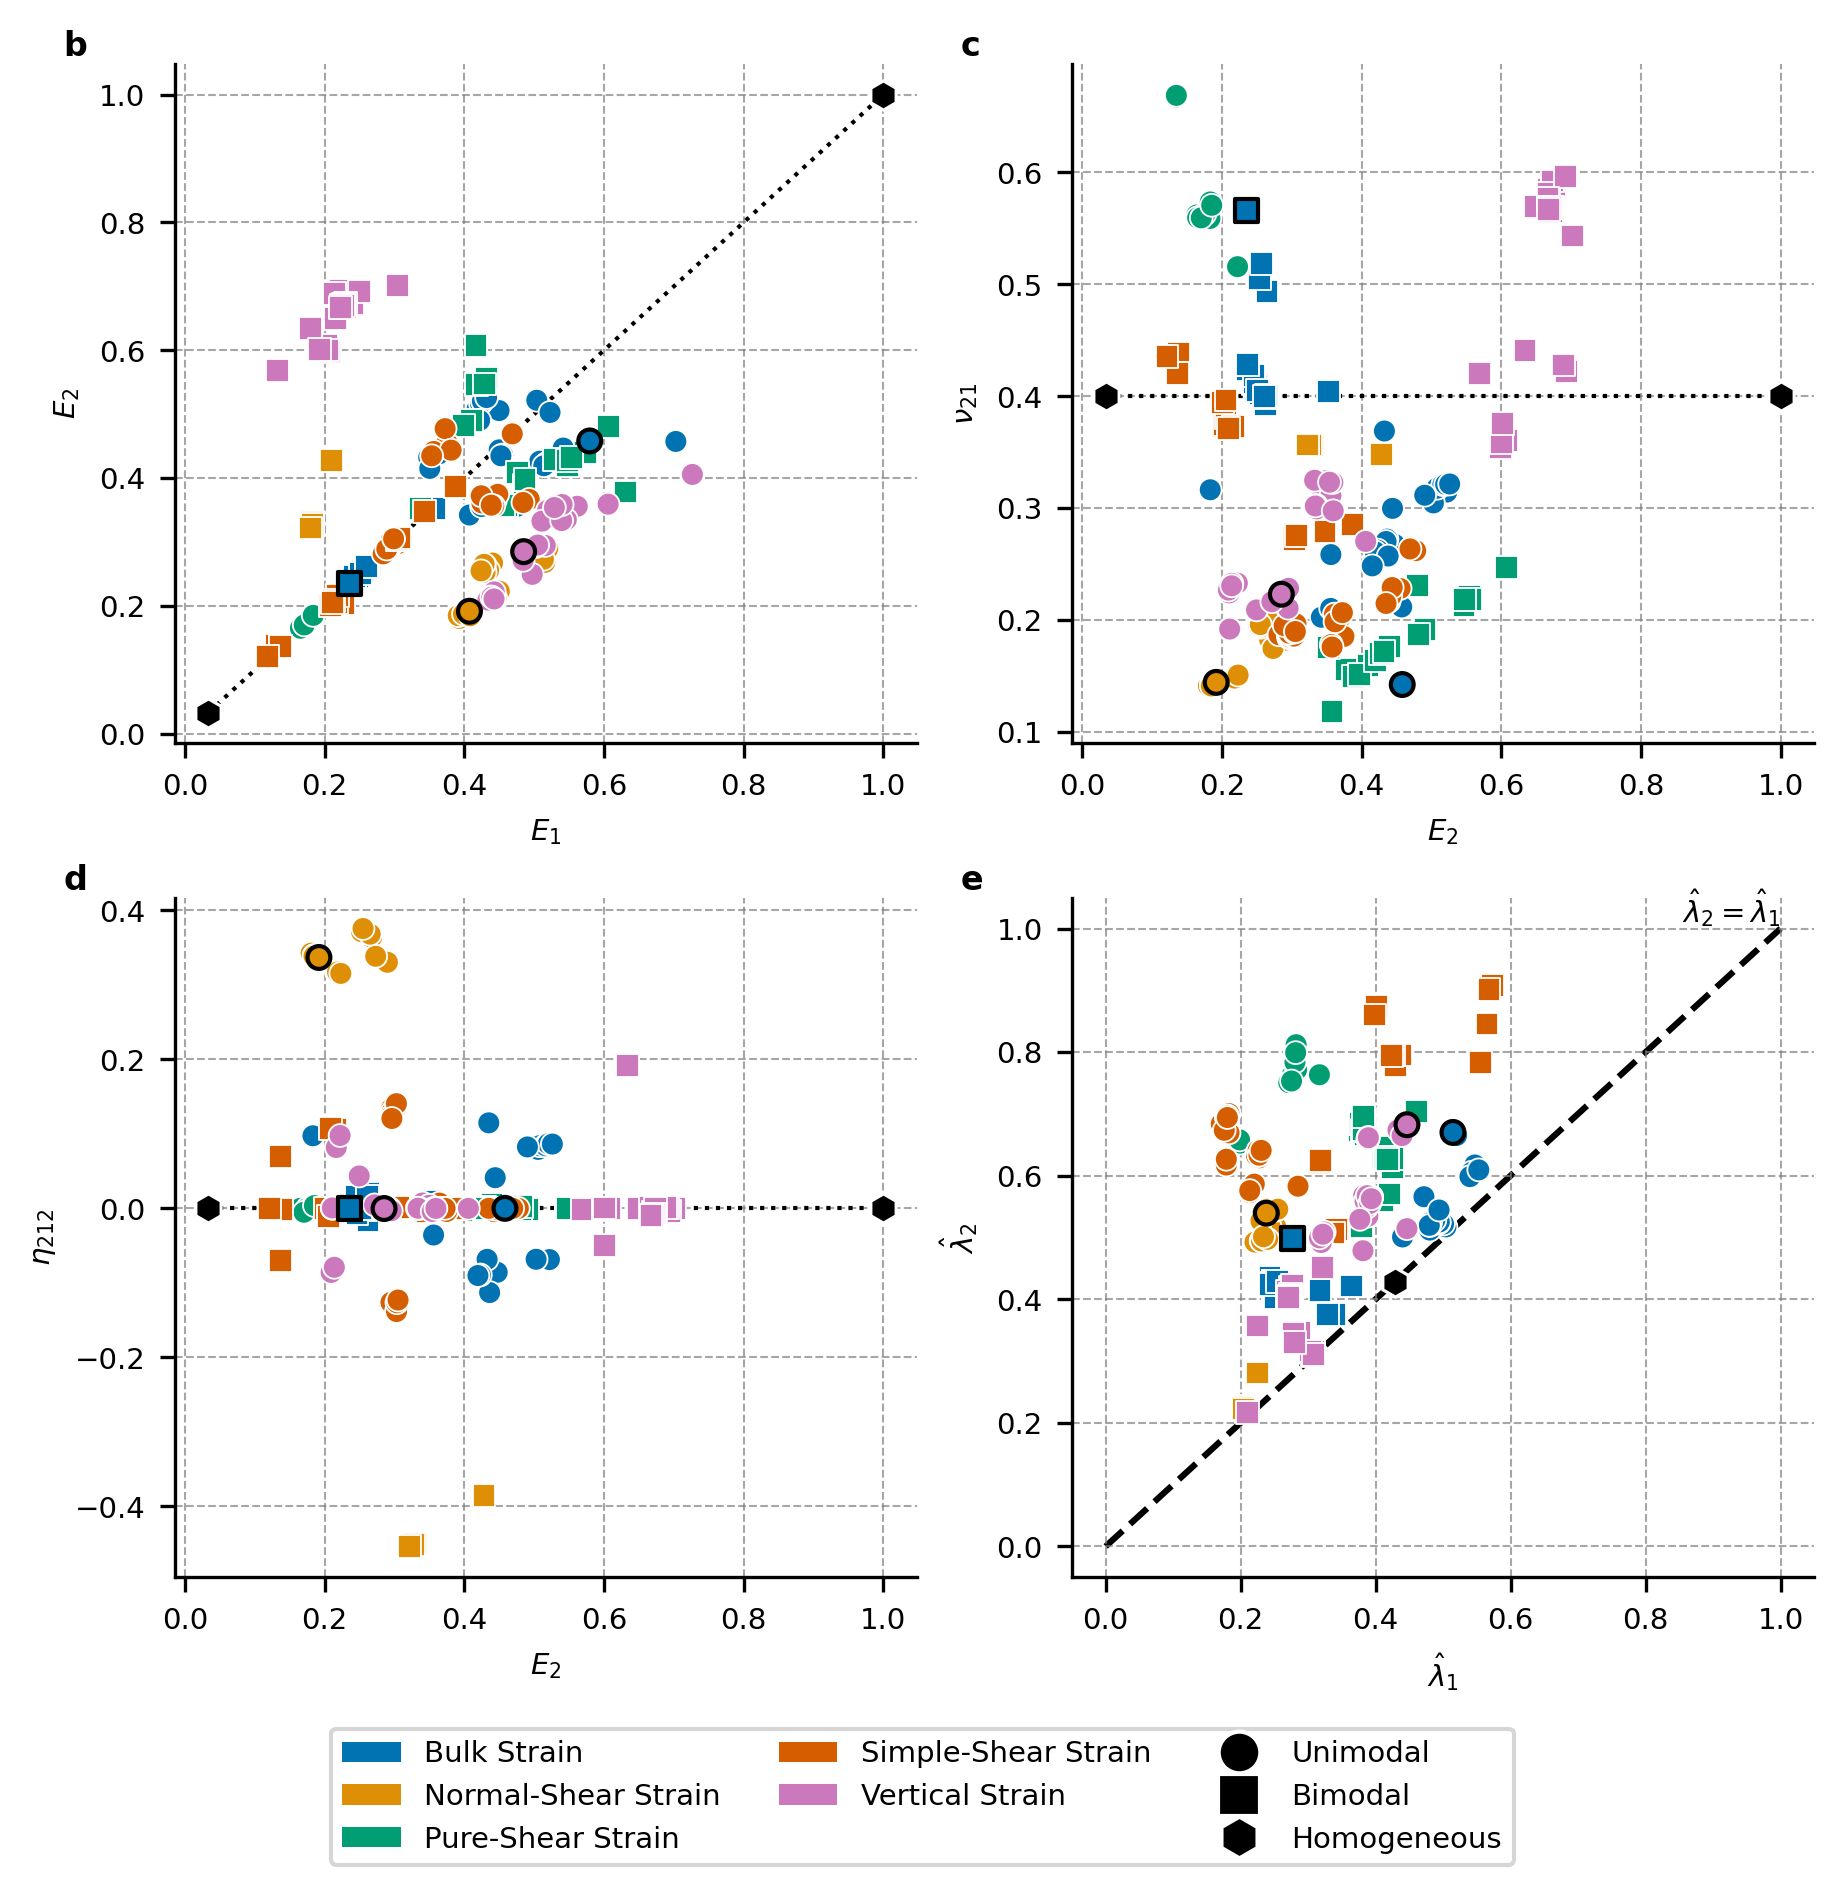

In [4]:
FONTSIZE = 7
cm2in = 1/2.54
width, height = 18*cm2in-1., 14.4*cm2in
fig, axs = plt.subplots(2, 2, figsize=(width, height))
strain_str_map = dict(
    BULK='Bulk Strain',
    VERT='Vertical Strain',
    NSC='Normal-Shear Strain',
    SSHEAR='Simple-Shear Strain',
    HOM='Homogeneous Sample',
    PSHEAR='Pure-Shear Strain'
)
# the same kwargs used for all plots
kwargs = dict(
    hue='basis_v',
    style='extremal_mode',
    markers={1: 'o', 2: 's', 0: 'h', },
    s=30,
    legend=False,
    palette='colorblind',
)
# pairs of x and y keys into the dataframe
xys = (
    ('E1', 'E2'),
    ('E2', 'nu21'),
    ('E2', 'eta122'),
    ('Normed_Eigenvalue_0', 'Normed_Eigenvalue_1')
)
# actual text we want as axes labels
xy_labs = (
    (r'$E_1$', r'$E_2$'),
    (r'$E_2$', r'$\nu_{21}$'),
    (r'$E_2$', r'$\eta_{212}$'),
    (r'$\hat{\lambda}_1$', r'$\hat{\lambda}_2$')
)

subplot_labs = (
    'b',
    'c',
    'd',
    'e'
)

for ax, xy, xy_lab, sp_lab in zip(axs.flatten(), xys, xy_labs, subplot_labs):
    # plot the homogeneous points and linear interploation between them
    line_data = df[df['extremal_mode'] == 0]
    sns.lineplot(data=line_data,
                 x=xy[0],
                 y=xy[1],
                 ax=ax,
                 color='k',  # sns.color_palette('colorblind')[7],
                 marker='h',
                 # scatter plot marker sizes 's' are specified in area (points^2). lineplot marker sizes are specified in points
                 markersize=7,  # np.sqrt(kwargs['s']),
                 linestyle=':',
                 zorder=1,
                 lw=1
                 )

    # plot the rest of the metamaterial data as a scatter plot
    sns.scatterplot(data=df[df['extremal_mode'] != 0],
                    x=xy[0],
                    y=xy[1],
                    ax=ax,
                    **kwargs
                    )

    # Replot the specific datapoints that I printed
    # We want to give them a different look to highlight them
    sns.scatterplot(data=hi_df,
                    x=xy[0],
                    y=xy[1],
                    ax=ax,
                    edgecolor='k',
                    lw=1,
                    hue_order=df['basis_v'].unique(),
                    **kwargs
                    )

    # set subplot font sizes
    ax.set_xlabel(xy_lab[0], fontsize=FONTSIZE)
    ax.set_ylabel(xy_lab[1], fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    # subplot labels
    ax.text(-0.15, 1.05, sp_lab,
            transform=ax.transAxes,
            fontsize=8,
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment='left',
            # fontfamily='Helvetica',
            )
    # add grid and make sure it is below data
    ax.grid(True, which='both', linestyle='--',
            linewidth=0.5, color='grey', alpha=0.7)
    ax.set_axisbelow(True)
    # remove unnecesarry spines
    [ax.spines[s].set_visible(False) for s in ('top', 'right')]

plt.tight_layout(pad=0.5)

# y=x for eigenvalue plot
axs[1][1].plot([0, 1], [0, 1], color='k', linestyle='--', zorder=0)
axs[1][1].text(1, 1, r'$\hat{\lambda}_2=\hat{\lambda}_1$', fontsize=FONTSIZE,
               verticalalignment='bottom', horizontalalignment='right')

color_legend = [Patch(facecolor=c, label=strain_str_map[l])
                for l, c in
                zip(df['basis_v'].unique(),
                    sns.color_palette(kwargs['palette'])[:5])]

marker_legend = [Line2D([0], [0],
                        marker=m,
                        color='w',
                        markerfacecolor='k',
                        markersize=10,
                        linestyle='None',
                        label=l)
                 for m, l in
                 zip(kwargs['markers'].values(),
                     ['Unimodal', 'Bimodal', 'Homogeneous'])]
# dummy legend adds a blank spot to the legend so all the markers are in their own column
dummy_legend = [Line2D([], [], color='none', label='')]

fig.legend(handles=color_legend + dummy_legend + marker_legend,
           loc='upper center',
           ncol=3,
           bbox_to_anchor=(0.5, 0.0),
           fontsize=FONTSIZE)

fname = f"images/{'SI_fig1' if SI_IMAGE else 'fig4'}.svg"
fig.savefig(fname, format='svg', bbox_inches='tight')